In [13]:
import pandas
import time
import sys
sys.path.append('.')
import RM_exact
import RM_approx
import RM_helper

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D


([[0.0, 1048.0263102735034, 2094.6606366864403, 3139.0685119142513, 4180.0195247359234, 5215.7604988764269, 6243.8791080427009, 7261.1727031240662, 8263.5432638608509, 9245.9439312714239, 10202.403743475792, 11126.15338785681, 12009.865141213644, 12846.005098103289, 13627.277216805309, 14347.119962255141, 15000.201488746874, 15582.852256170047, 16093.377260914627, 16532.204040330122, 16901.845120933624, 17206.680353849228, 17452.59026024905, 17646.491018835546, 17795.831548226841, 17908.112110277511, 17990.473292535902, 18049.387323854782, 18090.464531881502, 18118.370250755015, 18136.834443802676, 18148.729029245918, 18156.186234772227, 18160.73403828765, 18163.43014108932, 18164.982239236586, 18165.848257435056, 18166.314872377923, 18166.55578375917, 18166.672885300464, 18166.724060063923, 18166.741158053203, 18166.741158053203, 18166.741158053203, 18166.741158053203, 18166.741158053203, 18166.741158053203, 18166.741158053203, 18166.741158053203, 18166.741158053203, 18166.74115805320

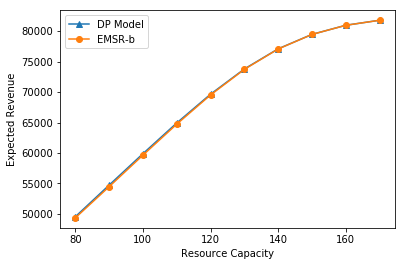

In [1]:
def compare_single_static(products, demands, cap_lb, cap_ub, cap_interval):
    """Compare the exact DP model with a heuristic, EMSR-b, for static models of single-resource RM problems."""
    col_titles = ['DP-rev', 'DP-protect', 'DP-time', 'EMSR-b-rev', 'EMSR-b-protect', 'EMSR-b-time','%Sum.Opt']
    capacities = [c for c in range(cap_lb, cap_ub + 1, cap_interval)]
    n_products = len(products)
    
    result = []
    for cap in capacities:
        dp_model = RM_exact.Single_RM_static(products, demands, cap)
        dp_time = time.time()
        dp_result = dp_model.value_func()
        dp_time = time.time() - dp_time
        
        approx_model = RM_approx.Single_EMSR(products, demands, cap)
        approx_time = time.time()
        approx_result = approx_model.value_func()
        approx_time = time.time() - approx_time
        
        dp_rev = dp_result[0][n_products - 1][cap]
        approx_rev = approx_result[0][n_products-1][cap]
        
        sub_optimal = (dp_rev - approx_rev) / dp_rev * 100
        result.append([round(dp_rev, 2), dp_result[1], round(dp_time, 2), round(approx_rev, 2), approx_result[1], \
                       round(approx_time, 2), "{0:.3f}%".format(sub_optimal)])
    
    print(pandas.DataFrame(result, capacities, col_titles))
    return result

# Examples, ref: example 2.3, 2.4 in "The Theory and Practice of Revenue Management"
products = [[1, 1050], [2,567], [3, 534], [4,520]]
# products=[[1, 1050], [2,950], [3, 699], [4,520]]
demands = [(17.3, 5.8), (45.1, 15.0), (39.6, 13.2), (34.0, 11.3)]
lb = 80
ub = 220
intervals = 15
result = compare_single_static(products, demands, lb, ub, 10)
x = np.linspace(lb, ub, intervals)
y1 = [r[0] for r in result]
y2 = [r[3] for r in result]

plt.clf()

line1, = plt.plot(x,y1, marker='^', label='DP Model')
line2, = plt.plot(x,y2, marker='o', label='EMSR-b')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=1),line2: HandlerLine2D(numpoints=1)})
plt.ylabel('Expected Revenue')
plt.xlabel('Resource Capacity')
# plt.show()
plt.savefig('Single-revs')

plt.clf()
y_diff = [float(r[6].strip('%')) for r in result]
plt.ylabel('Revenue Difference (%)')
plt.xlabel('Resource Capacity')
plt.plot(x, y_diff, 'ro-')

# plt.show()
plt.savefig('Single-Diff')


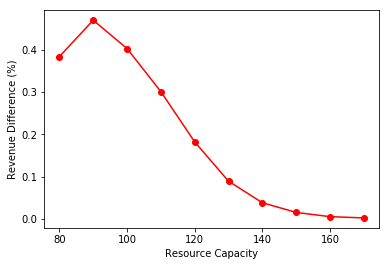

In [11]:
plt.clf()
DP_time = [r[2] for r in result]
approx_time = [r[5] for r in result]
line3, = plt.plot(x,DP_time, marker='^', label='DP Model')
line4, = plt.plot(x,approx_time, marker='o', label='EMSR-b')
plt.legend(handler_map={line3: HandlerLine2D(numpoints=1),line4: HandlerLine2D(numpoints=1)})
plt.ylabel('Running Time(s)')
plt.xlabel('Resource Capacity')
# plt.show()
plt.savefig('Single-times')

In [4]:
def compare_iDAVN_singleDPstatic(products, resources, n_class, cap_lb, cap_ub, cap_interval):
    """Compare the iterative DAVN method, with a collection of single-resource static DP model."""
    n_resources = len(resources)
    col_titles = ['DAVN:bid-p', 'DAVN:rev', 'DAVN:time']
    capacities = [c for c in range(cap_lb, cap_ub + 1, cap_interval)]
    for i in range(n_resources):
            resource_name = resources[i]
            col_titles.append('S-S: rev-' + resource_name)
    
    col_titles.append("S-S: sum")
    col_titles.append("S-S:total time")
    
    table_data = []
    (pros, demands, demands_with_names) = RM_helper.sort_product_demands(products)
    for cap in capacities:
        result= []
        caps = [cap] * n_resources
        
        DAVN_time = time.time()
        DAVN_bid_prices, DAVN_total_rev = RM_approx.iterative_DAVN(pros, resources, demands_with_names, n_class,\
                                                                   caps, caps)
        DAVN_time = time.time() - DAVN_time

        result.append(DAVN_bid_prices)
        result.append(DAVN_total_rev)
        result.append(DAVN_time)

        single_static_vf = []
        single_total_time =0
        for i in range(n_resources):
            resource_name = resources[i]
            products_i = [j for j in products if resource_name in j[0]]
            ps, ds, _ = RM_helper.sort_product_demands(products_i)
            
            single_time = time.time()
            problem = RM_exact.Single_RM_static(ps, ds, cap)
            vf_i = problem.value_func()
            single_time = time.time() - single_time
            single_total_time += single_time
            
            single_static_vf.append(vf_i[0][-1][-1])
            result.append(vf_i[0][-1][-1])
        result.append(sum(single_static_vf))
        result.append(single_total_time)
        
        table_data.append(result)
    
    print(pandas.DataFrame(table_data, capacities, col_titles))
    return table_data


# Compare
products = [['1a', (17.3, 5.8), 1050], ['2a', (45.1, 15.0),950], ['3a', (39.6, 13.2), 699], ['4a', (34.0, 11.3),520],\
            ['1b', (20, 3.5), 501], ['2b', (63.1, 2.5), 352], ['3b', (22.5, 6.1), 722], ['1ab', (11.5, 2.1), 760],\
            ['2ab', (24.3, 6.4), 1400]]
resources = ['a', 'b']
# compare_iDAVN_singleDPstatic(products,resources, 6, 80, 120, 10)
lb = 60
# ub = 160
ub = 70
data = compare_iDAVN_singleDPstatic(products, resources, 4, lb, ub, 10)

revs_DAVN = [d[1] for d in data]
revs_singleDP = [d[5] for d in data]
revs_diff_perc = [(d[1]-d[5]) / d[1] * 100 for d in data]
time_DAVN = [d[2] for d in data]
time_singleDP = [d[6] for d in data]

plt.clf()
x= np.linspace(lb, ub, (ub - lb) / 10 + 1)
line1, = plt.plot(x,revs_DAVN, marker='^', label='DAVN')
line2, = plt.plot(x,revs_singleDP, marker='o', label='Single_Static_DP')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=1),line2: HandlerLine2D(numpoints=1)})
plt.ylabel('Expected Revenue')
plt.xlabel('Resource Capacity')
# plt.show()
plt.savefig('DAVN-ssDP-revs')

plt.clf()
line3, = plt.plot(x,time_DAVN, marker='^', label='DAVN')
line4, = plt.plot(x,time_singleDP, marker='o', label='Single_Static_DP')

plt.legend(handler_map={line3: HandlerLine2D(numpoints=1),line4: HandlerLine2D(numpoints=1)})
plt.ylabel('Running Time(s)')
plt.xlabel('Resource Capacity')
# plt.show()
plt.savefig('DAVN-ssDP-time')
plt.clf()
plt.plot(x, revs_diff_perc, 'bo-')
plt.ylabel('Revenue Difference(%)')
plt.xlabel('Resource Capacity')
plt.savefig('DAVN-ssDP-diff')

stop at k =  3 , with static_bid_prices =  [572.55999999999995, 351.99599999999998] , with total expected revenue= 74052.9802457
products for ss: [['2ab', 1400], ['1a', 1050], ['2a', 950], ['1ab', 760], ['3a', 699], ['4a', 520]] cap =  60
products for ss: [['2ab', 1400], ['1ab', 760], ['3b', 722], ['1b', 501], ['2b', 352]] cap =  60
stop at k =  8 , with static_bid_prices =  [483.59100000000001, 340.34500000000003] , with total expected revenue= 83425.4849264
products for ss: [['2ab', 1400], ['1a', 1050], ['2a', 950], ['1ab', 760], ['3a', 699], ['4a', 520]] cap =  70
products for ss: [['2ab', 1400], ['1ab', 760], ['3b', 722], ['1b', 501], ['2b', 352]] cap =  70
            DAVN:bid-p      DAVN:rev  DAVN:time    S-S: rev-a    S-S: rev-b  \
60   [572.56, 351.996]  74052.980246  25.867110  65406.900185  55455.914856   
70  [483.591, 340.345]  83425.484926  65.740835  74321.894085  60465.759890   

         S-S: sum  S-S:total time  
60  120862.815041        9.231796  
70  134787.653975   

In [12]:
# Draw the graph of running time of the network_DP model
def eval_networkDP_changingCap(products, resources, cap_lb, cap_ub, total_time):
    """Evaluate the network DP method, trying with different capacities of resource, and different total time."""
    n_resources = len(resources)
    col_titles = ['Revenue', 'Bid Prices', 'Time']
    capacities = [c for c in range(cap_lb, cap_ub + 1)]
    
    table = []
    (pros, demands, demands_with_names) = RM_helper.sort_product_demands(products)
    for cap in capacities:
        caps = [cap] * n_resources
        
        result= []
        
        DP_time = time.time()
        problem = RM_exact.Network_RM(pros, resources, [demands], caps, total_time)
        DP_vf = problem.value_func()
        bid_prices = problem.bid_price(total_time, caps)
        DP_time = time.time() - DP_time

        result.append(DP_vf[0][-1])
        result.append(bid_prices)
        result.append(DP_time)
        
        table.append(result)
        
    print(pandas.DataFrame(table, capacities, col_titles))
    return table
        

ps1 = [['a1', 0.02, 200], ['a2', 0.06, 503], ['ab1', 0.08, 400],['ab2', 0.01, 704], ['b1', 0.05, 601], ['b2', 0.12, 106],\
            ['bc', 0.03, 920],['c1', 0.07, 832],['d1', 0.14, 397], ['d2',  0.18, 533], ['ad', 0.09, 935], \
      ['ae', 0.013, 205],['f3', 0.004, 589], ['fb', 0.009, 422]]
rs1 = ['a', 'b', 'c', 'd', 'e', 'f']

ps2 = [['a1', 0.02, 200], ['a2', 0.06, 503], ['ab1', 0.08, 400],['ab2', 0.01, 704], ['b1', 0.05, 601], \
      ['b2', 0.12, 106], ['bc', 0.03, 920],['c1', 0.07, 832]]
rs2 = ['a', 'b', 'c']

cap_ub = 8
T = 5
table1 = eval_networkDP_changingCap(ps1, rs1, 1, cap_ub,T)
table2 = eval_networkDP_changingCap(ps1, rs1, 1, cap_ub, 2*T)
table3 = eval_networkDP_changingCap(ps1, rs1, 1, cap_ub, 3*T)

x= np.linspace(1, cap_ub, cap_ub)
revs1 = [d[0] for d in table1]
time1 = [d[2] for d in table1]
revs2 = [d[0] for d in table2]
time2 = [d[2] for d in table2]
revs3 = [d[0] for d in table3]
time3 = [d[2] for d in table3]

plt.clf()
line1, = plt.plot(x,revs1, marker='^', label='max_time='+str(T))
line2, = plt.plot(x,revs2, marker='o', label='max_time='+str(T))
line3, = plt.plot(x,revs3, marker='x', label='max_time='+str(T))
# line2, = plt.plot(x,revs_singleDP, marker='o', label='Single_Static_DP')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=1),line2: HandlerLine2D(numpoints=1),line3: HandlerLine2D(numpoints=1)})
# legend = ax.legend(loc='upper center')
plt.ylabel('Expected Revenue')
plt.xlabel('Resource Capacity')
plt.show()
plt.savefig('network-DP-revs-6')

plt.clf()
line1, = plt.plot(x,time1, marker='^', label='max_time='+str(T))
line2, = plt.plot(x,time2, marker='o', label='max_time='+str(T))
line3, = plt.plot(x,time3, marker='x', label='max_time='+str(T))

plt.legend(handler_map={line1: HandlerLine2D(numpoints=1),line2: HandlerLine2D(numpoints=1),line3: HandlerLine2D(numpoints=1)})
plt.ylabel('Running Time(s)')
plt.xlabel('Resource Capacity')
# plt.show()
plt.savefig('network-DP-time-6')


Expected Revenue At Beginning is  1203.717
Expected Revenue At Beginning is  1852.419


KeyboardInterrupt: 